In [2]:
import os, gc, random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm
from time import time, ctime

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr, softmax

In [3]:
BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
TARGETS = [f"{lb}_vote" for lb in BRAIN_ACTIVITY]
TARGETS_PRED = [f"{lb}_pred" for lb in BRAIN_ACTIVITY]


In [4]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv, select_fold=None):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    
    if select_fold is not None:
        oof_df = oof_df[oof_df['fold']==select_fold]
    
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

CSV Path:  ./outputs/ResnetGRU_Reg015_SplVote_6_DS5_SiLU_BPF_oof_2.csv
Kaggle Score:  0.4929704309486724
Average KL Loss:  0.49297047
Average Prediction Entropy:  1.1622313


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,total_votes,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,...,15.0,0.053638,0.051525,0.128630,0.109346,0.461679,0.195182,4,5,0.625103
1,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,...,12.0,0.067973,0.045186,0.053972,0.101931,0.439595,0.291343,4,5,0.197227
2,9240926,0.0,0.181818,0.000000,0.000000,0.545455,0.272727,918152909,0.0,230.0,...,11.0,0.026257,0.117131,0.032340,0.086567,0.085545,0.652161,5,4,0.852677
3,17311157,0.0,0.000000,0.000000,0.000000,0.153846,0.846154,130237761,0.0,6.0,...,13.0,0.016638,0.120791,0.026798,0.151607,0.239099,0.445069,5,5,0.475796
4,21054661,0.0,0.000000,0.000000,0.800000,0.000000,0.200000,1067342787,118.0,484.0,...,15.0,0.016860,0.052093,0.017609,0.227380,0.352523,0.333533,4,3,0.904105


target
GPD        0.580561
GRDA       0.518508
LPD        0.565098
LRDA       0.625859
Other      0.381627
Seizure    0.917619
Name: kl_loss, dtype: float32


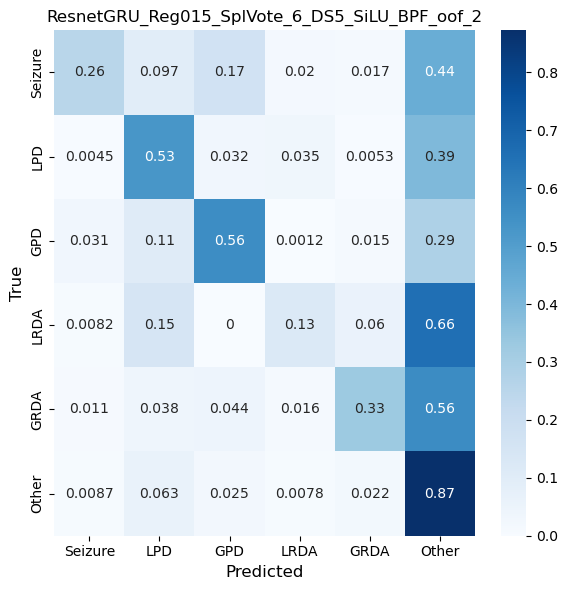

In [6]:
csv_path = './outputs/ResnetGRU_Reg015_SplVote_6_DS5_SiLU_BPF_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path, select_fold=None)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

pred_entropy = oof_df[TARGETS_PRED].apply(lambda x: entropy(x), axis=1)
print("Average Prediction Entropy: ", pred_entropy.mean())

display(oof_df.head())

print(oof_df.groupby(['target'])['kl_loss'].mean())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

CSV Path:  ./outputs/ResnetGRU_Reg015_SplVote_6_DS5_SiLU_LB048/ResnetGRU_Reg015_SplVote_6_DS5_SiLU_oof_2.csv
Kaggle Score:  0.45967331064492223
Average KL Loss:  0.45967332
Average Prediction Entropy:  1.1682546


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,total_votes,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,...,15.0,0.045760,0.105865,0.137786,0.120095,0.379620,0.210874,4,5,0.584226
1,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,...,12.0,0.051925,0.177938,0.039215,0.144415,0.104248,0.482259,5,5,0.422517
2,9240926,0.0,0.181818,0.000000,0.000000,0.545455,0.272727,918152909,0.0,230.0,...,11.0,0.023061,0.051254,0.012926,0.089133,0.069844,0.753781,5,4,1.074060
3,17311157,0.0,0.000000,0.000000,0.000000,0.153846,0.846154,130237761,0.0,6.0,...,13.0,0.019586,0.048349,0.067274,0.046327,0.227245,0.591220,5,5,0.243346
4,21054661,0.0,0.000000,0.000000,0.800000,0.000000,0.200000,1067342787,118.0,484.0,...,15.0,0.012263,0.070061,0.026753,0.208379,0.367573,0.314970,4,3,0.985369


target
GPD        0.444129
GRDA       0.486613
LPD        0.572787
LRDA       0.576495
Other      0.388786
Seizure    0.861331
Name: kl_loss, dtype: float32


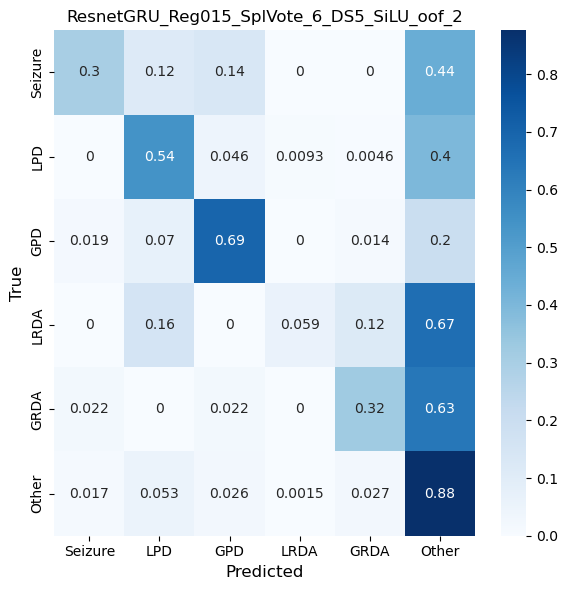

In [5]:
csv_path = f'./outputs/ResnetGRU_Reg015_SplVote_6_DS5_SiLU_LB048/ResnetGRU_Reg015_SplVote_6_DS5_SiLU_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path, select_fold=None)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

pred_entropy = oof_df[TARGETS_PRED].apply(lambda x: entropy(x), axis=1)
print("Average Prediction Entropy: ", pred_entropy.mean())

display(oof_df.head())

print(oof_df.groupby(['target'])['kl_loss'].mean())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

Average KL loss

Reg=0.10
GPD        0.690402
GRDA       0.808140
LPD        0.792532
LRDA       1.289242
Other      0.584849
Seizure    1.180930

Reg=0.05
GPD        0.595413
GRDA       0.835554
LPD        0.867681
LRDA       1.312258
Other      0.495525
Seizure    1.111998

Reg=0.00
GPD        0.587408
GRDA       0.826914
LPD        0.862832
LRDA       1.369003
Other      0.468457
Seizure    1.163169

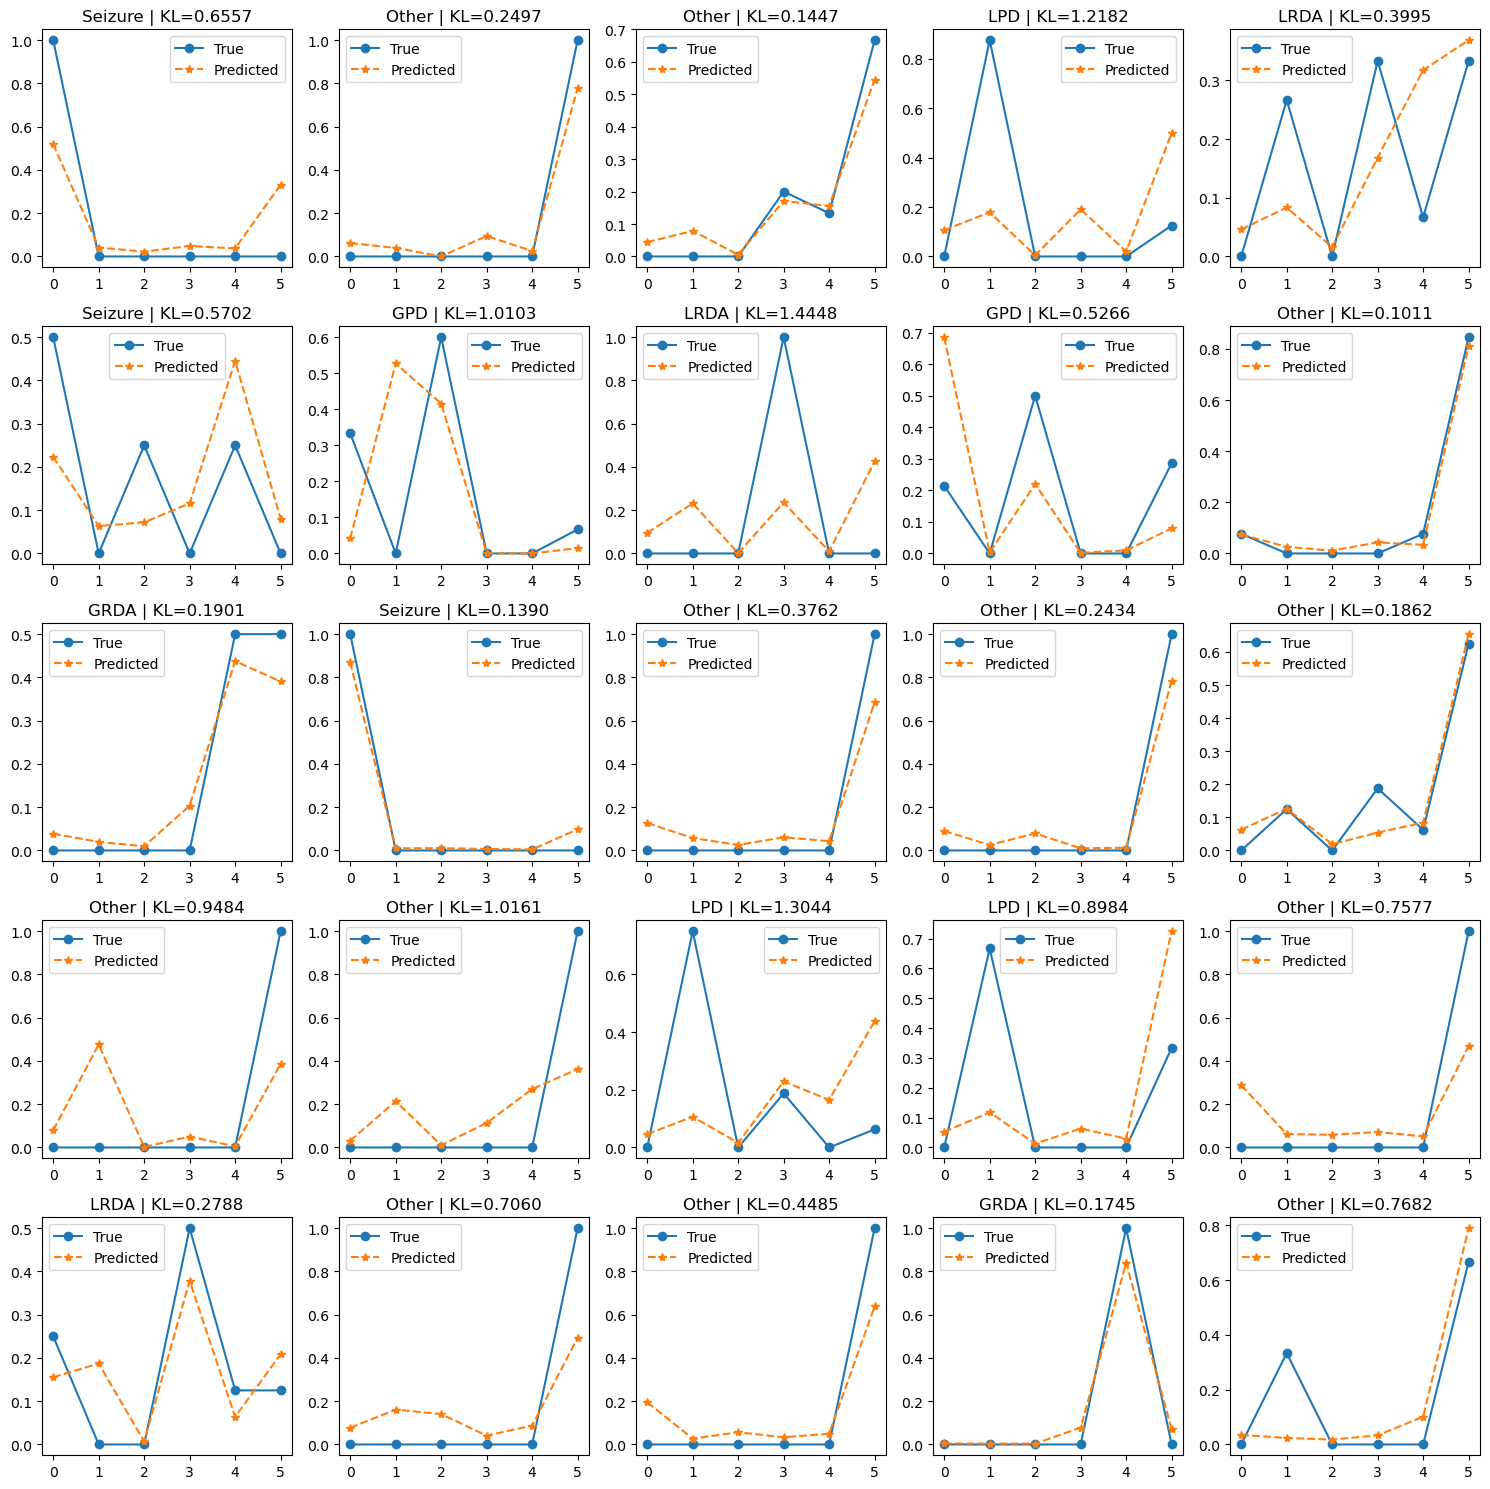

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
oof_samples = oof_df.sample(axes.size)

for i, ax in enumerate(axes.flatten()):
    row = oof_samples.iloc[i]
    x = np.arange(6)
    ax.plot(x, row[TARGETS].T, marker="o", ls="-", label="True")
    ax.plot(x, row[TARGETS_PRED].T, marker="*", ls="--", label="Predicted")
    ax.set_title(f"{row['target']} | KL={row['kl_loss']:.4f}")
    ax.legend()
    
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_samples.png")
plt.show()